In [1]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

import scripts.read_data_from_db as rd
import scripts.data_cleaning as dc
import scripts.utils as util

In [3]:
df = rd.read_data(table_name='processed_data')

INFO:scripts.read_data_from_db:Data fetched succesfully


In [5]:
pysqldf = lambda q: sqldf(q, globals())

### Aggregate of Average values

In [44]:
def helper(field1 : str, field2 : str) -> pd.DataFrame:
    query = f''' 
        SELECT
            "MSISDN/Number" AS CustomerID,
            AVG("{field1}") AS AvgDL,
            AVG("{field2}") AS AvgUL,
            (
                AVG("{field1}") + 
                AVG("{field2}")
            ) / 2 AS Avg
        FROM df
        GROUP BY "MSISDN/Number";
    '''
    return pysqldf(query)

#### Aggregate per customer of Average TCP retransmission

In [45]:
avg_retransmission = helper("TCP DL Retrans. Vol (Bytes)", "TCP UL Retrans. Vol (Bytes)")
avg_retransmission

,CustomerID,AvgDL,AvgUL,Avg
0,3.360100e+10,2.080991e+07,759658.664811,1.078479e+07
1,3.360100e+10,2.080991e+07,759658.664811,1.078479e+07
2,3.360100e+10,2.080991e+07,759658.664811,1.078479e+07
3,3.360101e+10,2.080991e+07,759658.664811,1.078479e+07
4,3.360101e+10,1.507977e+07,390430.332406,7.735101e+06
...,...,...,...,...
106851,3.379000e+10,2.150440e+05,3001.000000,1.090225e+05
106852,3.379000e+10,2.080991e+07,759658.664811,1.078479e+07
106853,3.197021e+12,2.080991e+07,759658.664811,1.078479e+07
106854,3.370000e+14,2.080991e+07,759658.664811,1.078479e+07


##### Aggregate of Average RTT per customer

In [46]:
avg_rtt = helper("Avg RTT DL (ms)", "Avg RTT UL (ms)")
avg_rtt

,CustomerID,AvgDL,AvgUL,Avg
0,3.360100e+10,46.000000,17.662883,31.831441
1,3.360100e+10,30.000000,1.000000,15.500000
2,3.360100e+10,109.795706,17.662883,63.729294
3,3.360101e+10,69.000000,15.000000,42.000000
4,3.360101e+10,57.000000,11.331441,34.165721
...,...,...,...,...
106851,3.379000e+10,42.000000,10.000000,26.000000
106852,3.379000e+10,34.000000,6.000000,20.000000
106853,3.197021e+12,109.795706,17.662883,63.729294
106854,3.370000e+14,109.795706,17.662883,63.729294


##### Aggregate of handset type per customer

In [47]:
query = ''' 
    SELECT
        "MSISDN/Number" AS User_MSISDN,
        "Handset Type" AS HandsetType,
        COUNT(*) AS HandsetTypeCount
    FROM df
    GROUP BY "MSISDN/Number", "Handset Type";

'''

count_handset = pysqldf(query) 
count_handset

,User_MSISDN,HandsetType,HandsetTypeCount
0,3.360100e+10,Huawei P20 Lite Huawei Nova 3E,1
1,3.360100e+10,Apple iPhone 7 (A1778),1
2,3.360100e+10,undefined,1
3,3.360101e+10,Apple iPhone 5S (A1457),1
4,3.360101e+10,Apple iPhone Se (A1723),2
...,...,...,...
106958,3.379000e+10,Huawei Honor 9 Lite,1
106959,3.379000e+10,Apple iPhone 8 Plus (A1897),1
106960,3.197021e+12,Quectel Wireless. Quectel Ec25-E,1
106961,3.370000e+14,Huawei B525S-23A,1


##### Aggregate of Average througput


In [48]:
avg_throughput = helper("Avg Bearer TP DL (kbps)", "Avg Bearer TP UL (kbps)")
avg_throughput

,CustomerID,AvgDL,AvgUL,Avg
0,3.360100e+10,37.0,39.0,38.0
1,3.360100e+10,48.0,51.0,49.5
2,3.360100e+10,48.0,49.0,48.5
3,3.360101e+10,204.0,44.0,124.0
4,3.360101e+10,20197.5,8224.5,14211.0
...,...,...,...,...
106851,3.379000e+10,9978.0,387.0,5182.5
106852,3.379000e+10,68.0,48.0,58.0
106853,3.197021e+12,1.0,0.0,0.5
106854,3.370000e+14,11.0,22.0,16.5


### The 10 top and bottom most frequent values

In [49]:
def helper(field, order):
    query = f''' 
        SELECT 
            "{field}",
            COUNT("{field}") AS "Frequency of {field}"
        FROM df
        GROUP BY "{field}"
        ORDER BY "Frequency of TCP" {order} 
        LIMIT 10;
    '''

    return pysqldf(query)

##### Top TCP values

In [27]:
top_tcp = helper("TCP DL Retrans. Vol (Bytes)", "DESC")
top_tcp

,TCP DL Retrans. Vol (Bytes),Frequency of TCP
0,2.080991e+07,100753
1,5.320000e+03,102
2,7.980000e+03,62
3,6.650000e+03,45
4,1.064000e+04,39
5,9.310000e+03,36
6,5.272000e+03,30
7,2.128000e+04,22
8,7.320000e+03,22
9,1.330000e+04,21


##### Bottom TCP values

In [28]:
bottom_tcp = helper("TCP DL Retrans. Vol (Bytes)", "ASC")
bottom_tcp

,TCP DL Retrans. Vol (Bytes),Frequency of TCP
0,4316.0,1
1,4317.0,1
2,4318.0,1
3,4320.0,1
4,4321.0,1
5,4322.0,1
6,4330.0,1
7,4331.0,1
8,4339.0,1
9,4341.0,1


##### Top RTT values

In [50]:
top_rtt = helper("Avg RTT DL (ms)", "DESC")
top_rtt

,Avg RTT DL (ms),Frequency of Avg RTT DL (ms)
0,227.0,36
1,226.0,48
2,225.0,39
3,224.0,49
4,223.0,43
5,222.0,35
6,221.0,44
7,220.0,53
8,219.0,38
9,218.0,55


##### Bottom RTT values

In [51]:
bottom_rtt = helper("Avg RTT DL (ms)", "ASC")
bottom_rtt

,Avg RTT DL (ms),Frequency of Avg RTT DL (ms)
0,23.0,1689
1,24.0,2405
2,25.0,2208
3,26.0,2488
4,27.0,3380
5,28.0,3553
6,29.0,2498
7,30.0,2012
8,31.0,1826
9,32.0,1986


##### Top Throughput values

In [33]:
top_throughput = helper("Avg Bearer TP DL (kbps)", "Desc")
top_throughput

,Avg Bearer TP DL (kbps),Frequency of TCP
0,23.0,7324
1,43.0,4352
2,44.0,4186
3,6.0,3983
4,22.0,2867
5,48.0,2778
6,63.0,2757
7,42.0,2689
8,45.0,2644
9,47.0,2263


##### Bottom Throughput values

In [34]:
bottom_throughput = helper("Avg Bearer TP DL (kbps)", "ASC")
bottom_throughput

,Avg Bearer TP DL (kbps),Frequency of TCP
0,599.0,1
1,662.0,1
2,667.0,1
3,692.0,1
4,700.0,1
5,710.0,1
6,748.0,1
7,784.0,1
8,831.0,1
9,842.0,1


### Aggregate per handset

In [53]:
def helper(field1, field2):
    query = f'''
        SELECT
            "Handset Type" AS HandsetType,
            AVG("{field1}" + "{field2}") / 2 AS Average
        FROM df
        GROUP BY "Handset Type"
        ORDER BY Average DESC;
    '''
    return pysqldf(query)

##### Average throguthput per handset

In [54]:
avg_throughput_per_handset = helper("Avg Bearer TP DL (kbps)", "Avg Bearer TP UL (kbps)")
avg_throughput_per_handset

,HandsetType,Average
0,Huawei B715S-23C,54497.115385
1,New-Bund Technol. Mix 2,52605.500000
2,Lg G6+,50067.500000
3,Zyxel Communicat. Sbg3600,48675.500000
4,Huawei Y9 2019,45869.500000
...,...,...
1391,Quectel Wireless. Quectel Ec21-E,1.000000
1392,Concox Informati. Concox Gt06 Gt06N Tr06,1.000000
1393,Quectel Wireless. Quectel Ec25-E,0.500000
1394,Wct Uno,0.000000


##### Average TCP per handset

In [55]:
average_tcp_per_handset = helper("TCP DL Retrans. Vol (Bytes)", "TCP UL Retrans. Vol (Bytes)")
average_tcp_per_handset

,HandsetType,Average
0,Gemalto M2M Gmbh Cinterion Pls8-E,1.078479e+07
1,Zyxel Communicat. Zyxel Wah7706,1.078479e+07
2,Zyxel Communicat. Sbg3600,1.078479e+07
3,Zyxel Communicat. Lte7460,1.078479e+07
4,Zte Zte Blade C2 Smartphone Android By Sfr Sta...,1.078479e+07
...,...,...
1391,Acer Liquid Zest 4G,5.571000e+03
1392,Huawei Nova 2,4.625000e+03
1393,Lenovo Moto C,4.444500e+03
1394,Acer Zx Z130,4.443000e+03


#### K-means Clustering

##### Creating aggregates

In [60]:
query = ''' 
    SELECT 
        "MSISDN/Number" AS CustomerID,
        (AVG("TCP DL Retrans. Vol (Bytes)") + AVG("TCP UL Retrans. Vol (Bytes)")) / 2 AS AvgTCP,
        (AVG("Avg RTT DL (ms)") + AVG("Avg RTT UL (ms)")) / 2 AS AvgRTT,
        (AVG("Avg Bearer TP DL (kbps)") + AVG("Avg Bearer TP UL (kbps)")) / 2 AS AvgThroughput
    FROM df
    GROUP BY CustomerID
'''

agg_df = pysqldf(query)
agg_df.head()

,CustomerID,AvgTCP,AvgRTT,AvgThroughput
0,3.360100e+10,1.078479e+07,31.831441,38.0
1,3.360100e+10,1.078479e+07,15.500000,49.5
2,3.360100e+10,1.078479e+07,63.729294,48.5
3,3.360101e+10,1.078479e+07,42.000000,124.0
4,3.360101e+10,7.735101e+06,34.165721,14211.0


##### Normalizing values

In [61]:
scaler = MinMaxScaler()
columns_to_normalize = ["AvgTCP", "AvgRTT","AvgThroughput"]

customer_id = agg_df['CustomerID']
transformed_data = scaler.fit_transform(agg_df[columns_to_normalize])
normalized_data = pd.DataFrame(transformed_data, columns=columns_to_normalize)

df_normalized = pd.concat([customer_id, normalized_data], axis=1)
df_normalized

,CustomerID,AvgTCP,AvgRTT,AvgThroughput
0,3.360100e+10,1.000000,0.163896,0.000268
1,3.360100e+10,1.000000,0.028926,0.000349
2,3.360100e+10,1.000000,0.427515,0.000342
3,3.360101e+10,1.000000,0.247934,0.000873
4,3.360101e+10,0.717138,0.183188,0.100102
...,...,...,...,...
106851,3.379000e+10,0.009811,0.115702,0.036505
106852,3.379000e+10,1.000000,0.066116,0.000409
106853,3.197021e+12,1.000000,0.427515,0.000004
106854,3.370000e+14,1.000000,0.427515,0.000116


##### Handle outlier values

In [62]:
processed_df = dc.handle_outliers(df_normalized, columns_to_normalize)

##### Find the optimal value of K

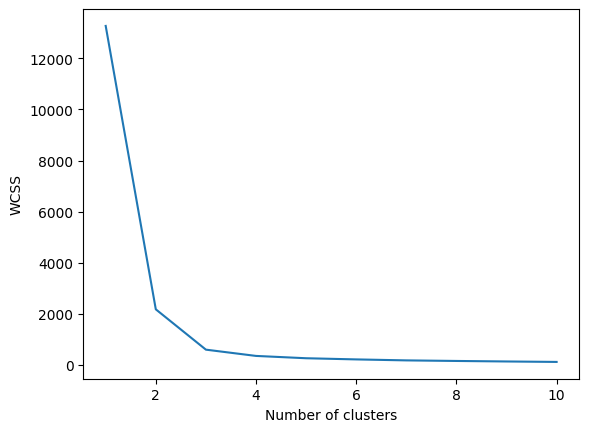

In [63]:
wcss = []
X = processed_df.iloc[:, [1, 3]]

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The optimal k = 3

##### Plot before clustering

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(processed_df["AvgTCP"], processed_df["AvgRTT"], processed_df["AvgThroughput"], c='blue', marker='o')

ax.set_xlabel("AvgTCP")
ax.set_ylabel("AvgRTT")
ax.set_zlabel("AvgThroughput")

plt.title('3D Scatter Plot of AvgTCP, AvgRTT, and AvgThroughput')
plt.show()